In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 24.3 MB/s eta 0:00:00


In [2]:
from zipfile import ZipFile
import os
import shutil

from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow

from ultralytics import YOLO


In [3]:
!mkdir ~/.kaggle

In [4]:
! cp /content/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mahmoudeldebase/egyptian-cars-plates

Dataset URL: https://www.kaggle.com/datasets/mahmoudeldebase/egyptian-cars-plates
License(s): apache-2.0
 97% 191M/196M [00:03<00:00, 60.5MB/s]
100% 196M/196M [00:03<00:00, 64.5MB/s]


In [7]:
# Put on the same directory

# specifying the name of the zip file
file = "/content/egyptian-cars-plates.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
EALPR Vechicles dataset/Vehicles Labeling/0001.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0002.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0003.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0004.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0005.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0006.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0007.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0008.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0009.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0010.txt 2023-07-16 14:31:02           39
EALPR Vechicles dataset/Vehicles Labeling/0011.txt 2023-07-16 14:31:02          

In [8]:

# Define paths
vichels_folder = '/content/EALPR_Vechicles_dataset/Vehicles'
labels_folder = '/content/EALPR_Vechicles_dataset/Vehicles_Labeling'


# Create directories for train, val, and test
os.makedirs('data/train/images', exist_ok=True)
os.makedirs('data/train/labels', exist_ok=True)
os.makedirs('data/val/images', exist_ok=True)
os.makedirs('data/val/labels', exist_ok=True)
os.makedirs('data/test/images', exist_ok=True)
os.makedirs('data/test/labels', exist_ok=True)

# List all files in the vichels folder
vichels_files = os.listdir(vichels_folder)

# Split data into train+val and test
train_val_vichels, test_vichels = train_test_split(vichels_files, test_size=0.2, random_state=42)

# Further split train_val into train and val
train_vichels, val_vichels = train_test_split(train_val_vichels, test_size=0.2, random_state=42)

# Function to move files
def move_files(files, src_folder, dst_folder, labels_folder):
    for file in files:
        # Move the image file
        src_image_path = os.path.join(src_folder, file)
        dst_image_path = os.path.join(dst_folder, 'images', file)
        dst_unlabeled_image_path = os.path.join('data/unlabeled_images', file)


        # Move the corresponding label file, if it exists
        if file.lower().endswith('.jpg'):
            label_file = file.lower().replace('.jpg', '.txt')
        else:
          label_file = file.replace('.jpeg', '.txt')  # Adjust the extension as needed

        src_label_path = os.path.join(labels_folder, label_file)
        dst_label_path = os.path.join(dst_folder, 'labels', label_file)

        if os.path.exists(src_label_path):
            shutil.move(src_label_path, dst_label_path)
            shutil.move(src_image_path, dst_image_path)
        else:
            print(f"Warning: Label file not found for {file}. Skipping.")

# Move the files to the respective directories
move_files(train_vichels, vichels_folder, 'data/train', labels_folder)
move_files(val_vichels, vichels_folder, 'data/val', labels_folder)
move_files(test_vichels, vichels_folder, 'data/test', labels_folder)


In [9]:
train = os.listdir('/content/data/train/images')
val_vichels = os.listdir('/content/data/val/images')
test_vichels = os.listdir('/content/data/test/images')
print( 'train:',len(train) ,'val:' , len(val_vichels) ,'test:', len(test_vichels))

train: 1335 val: 334 test: 418


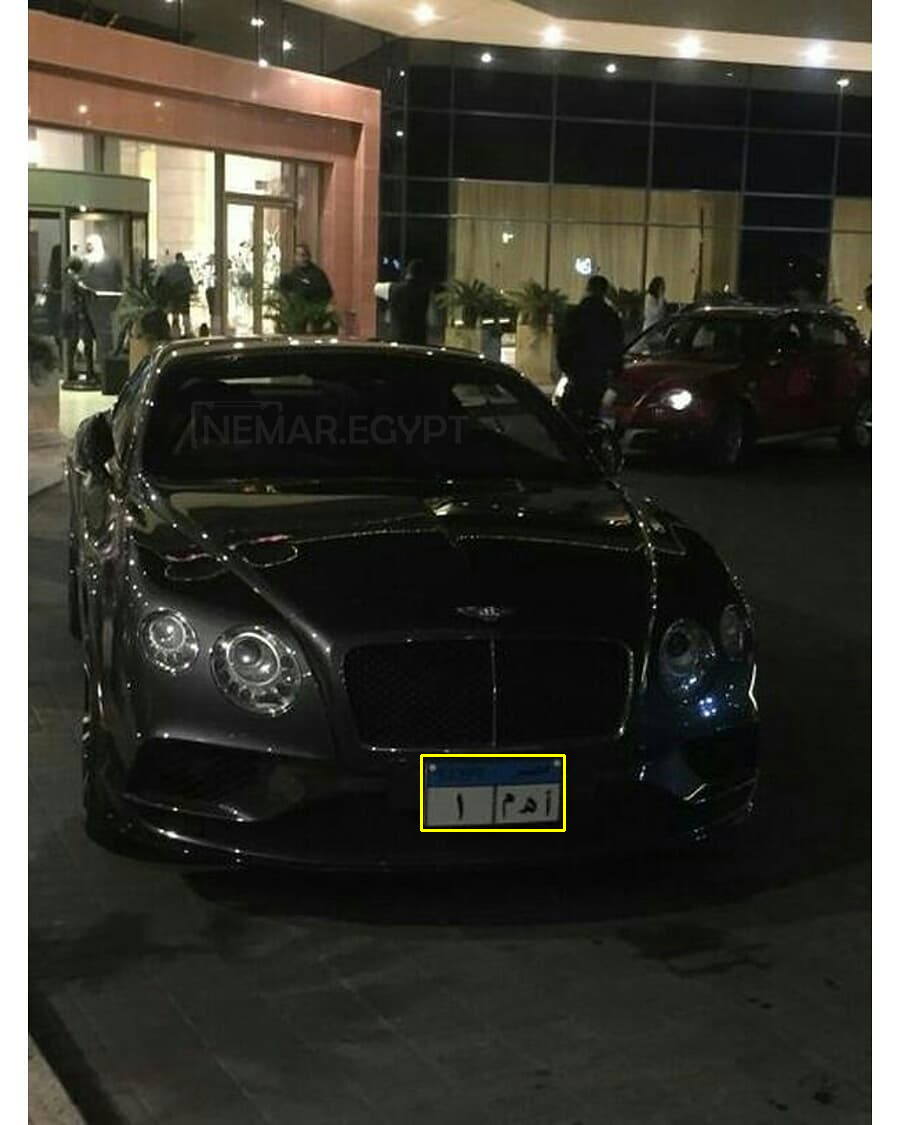

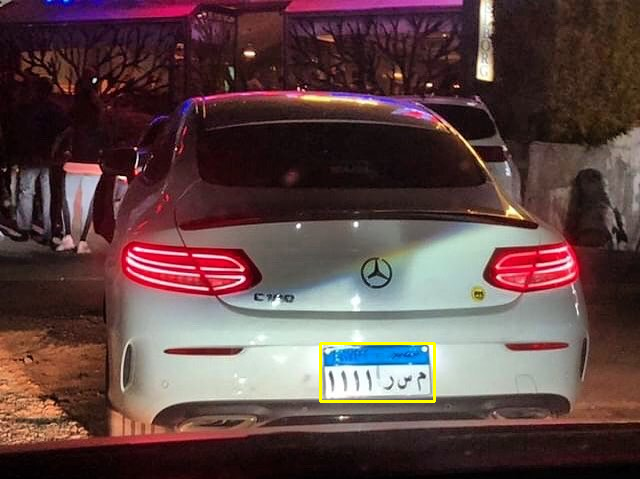

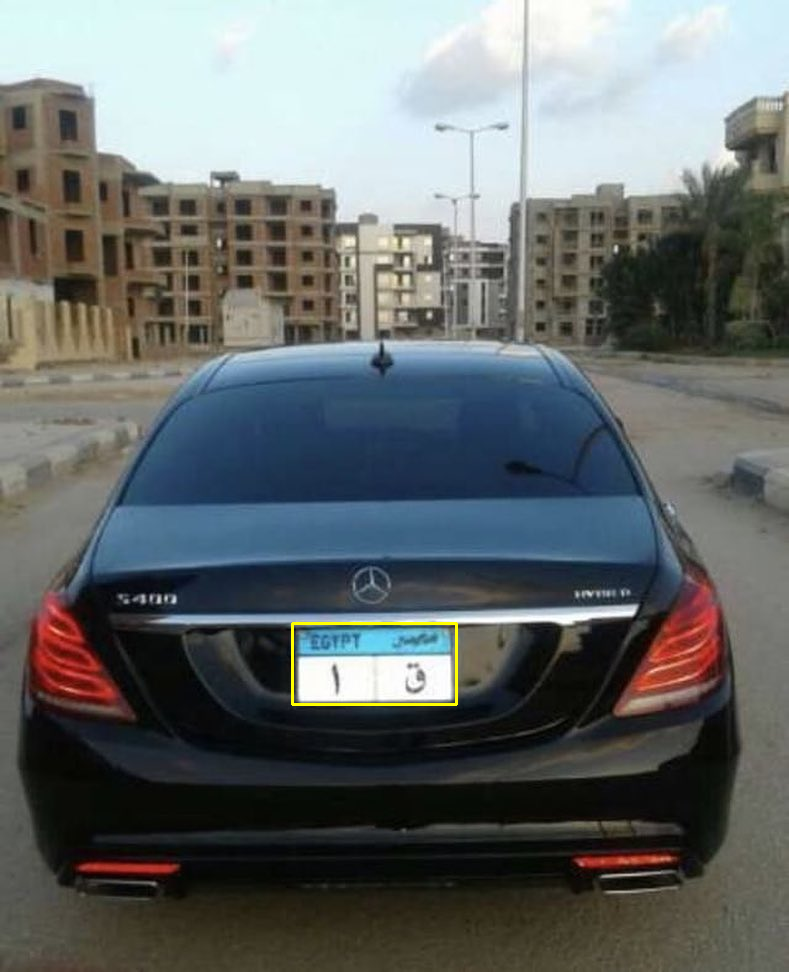

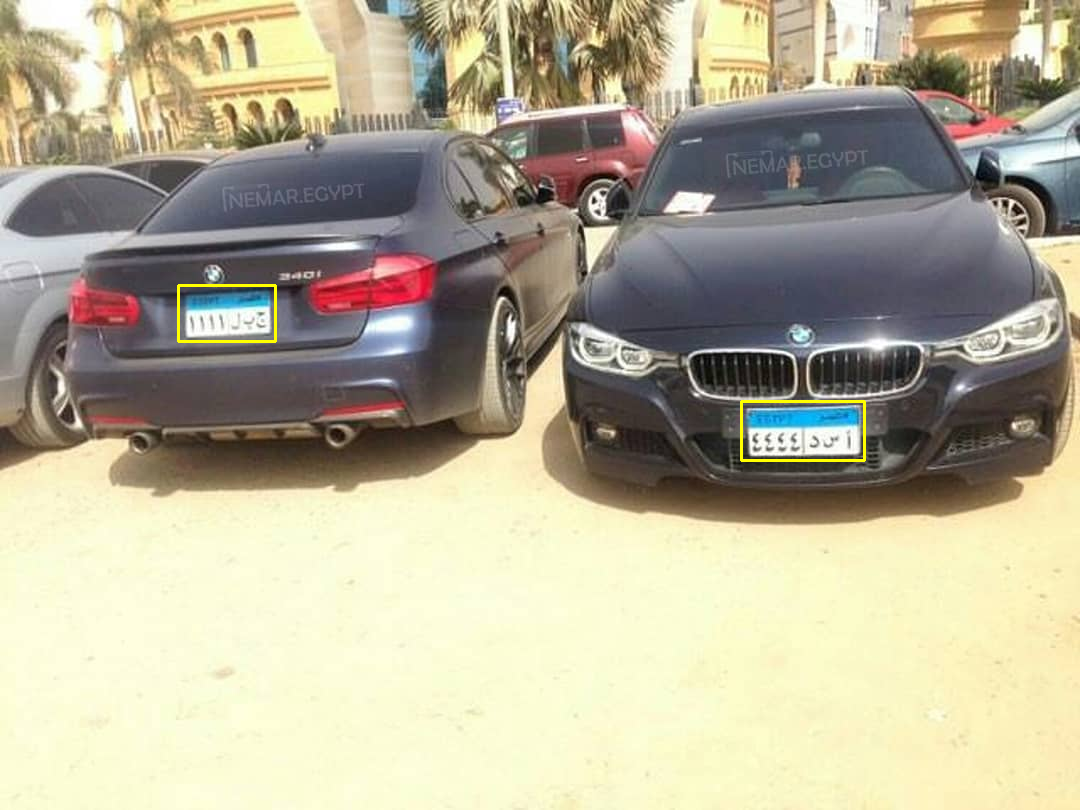

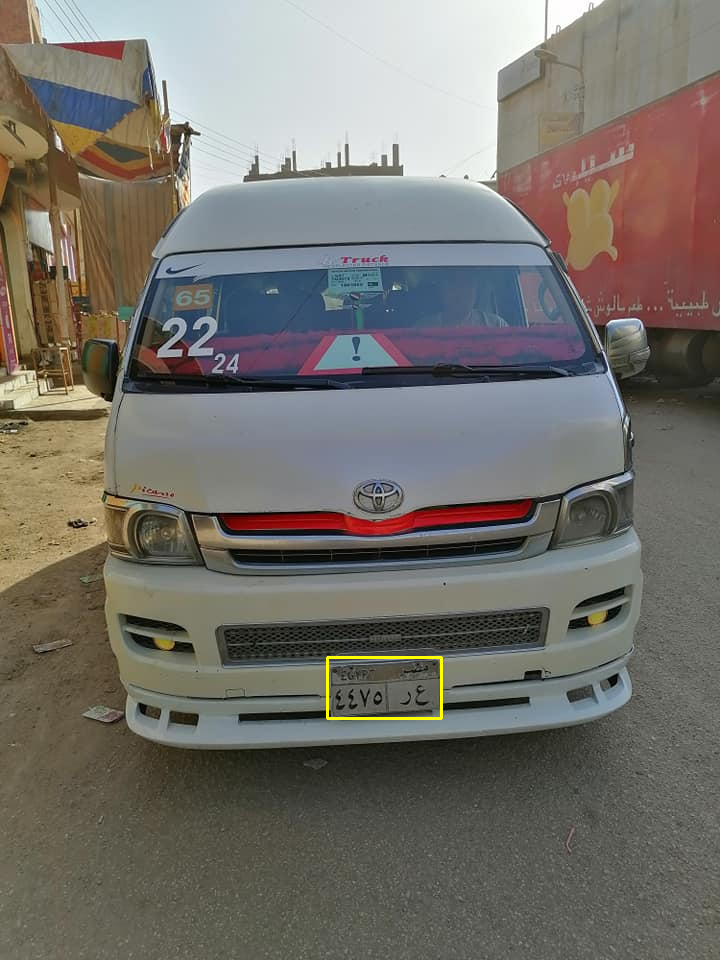

In [10]:

# Path to the training data
train_vichels_folder = 'data/train/images'
train_labels_folder = 'data/train/labels'

# List all files in the training vichels folder
train_vichels_files = os.listdir(train_vichels_folder)

# Select a sample file (for example, the first one)
sample_files = train_vichels_files[:5]

for sample_file in sample_files:
    # Load the image
    image_path = os.path.join(train_vichels_folder, sample_file)
    image = cv2.imread(image_path)

    # Get image dimensions
    height, width, _ = image.shape

    # Load the corresponding label
    label_file = sample_file.replace('.jpg', '.txt').replace('.JPG', '.txt')
    label_path = os.path.join(train_labels_folder, label_file)

    # Read the label content and draw bounding boxes
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Assuming label format: class_id x_center y_center width height (normalized values)
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_width, box_height = map(float, parts[1:])

            # Convert normalized coordinates to absolute coordinates
            x_center_abs = int(x_center * width)
            y_center_abs = int(y_center * height)
            box_width_abs = int(box_width * width)
            box_height_abs = int(box_height * height)

            # Calculate the top-left and bottom-right coordinates of the bounding box
            x1 = int(x_center_abs - box_width_abs / 2)
            y1 = int(y_center_abs - box_height_abs / 2)
            x2 = int(x_center_abs + box_width_abs / 2)
            y2 = int(y_center_abs + box_height_abs / 2)

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

            # Add the label text near the bounding box
            #label_text = f'Class {class_id}'
            #cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Display the image with the bounding box and label using cv2_imshow
    cv2_imshow(image)


In [ ]:

# Load YOLOv10n model from scratch
model = YOLO("yolov10n.yaml")

In [ ]:

# Train the model
model.train(data="/content/licence_plate_recognition.yaml", epochs=100, imgsz=640)

Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.yaml, data=/content/licence_plate_recognition.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

100%|██████████| 755k/755k [00:00<00:00, 24.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 121MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 1334 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1335/1335 [00:00<00:00, 1900.43it/s]

train: WARNING ⚠️ /content/data/train/images/2018.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)


train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/val/labels... 334 images, 0 backgrounds, 0 corrupt: 100%|██████████| 334/334 [00:00<00:00, 1055.16it/s]

val: New cache created: /content/data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.05G      7.212      19.51      7.754          7        640: 100%|██████████| 84/84 [00:47<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.50it/s]

                   all        334        342   9.98e-06    0.00292   5.13e-06   1.01e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         3G      4.307      8.755      4.701          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]

                   all        334        342      0.446      0.111      0.165      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.98G      3.494       5.14      3.896         12        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        334        342      0.571      0.257      0.313       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.98G       3.15      3.842      3.598         15        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]

                   all        334        342       0.56      0.611      0.602      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.98G      2.752      2.832      3.243         15        640: 100%|██████████| 84/84 [00:43<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.64it/s]

                   all        334        342      0.589      0.594      0.652      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.98G      2.608      2.479      3.102          7        640: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]

                   all        334        342       0.78      0.716      0.805      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.98G      2.378      2.045      2.817         15        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

                   all        334        342      0.859      0.769       0.88      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.98G      2.165      1.759       2.67         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]

                   all        334        342      0.858      0.819      0.916      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.98G       2.09      1.607      2.599         17        640: 100%|██████████| 84/84 [00:42<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]

                   all        334        342       0.74       0.81       0.85       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.98G      2.041      1.591       2.55         10        640: 100%|██████████| 84/84 [00:41<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

                   all        334        342      0.912      0.819      0.937      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.98G      1.963      1.421      2.471         11        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]

                   all        334        342      0.853      0.901      0.944      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.98G      1.912      1.405      2.445          7        640: 100%|██████████| 84/84 [00:42<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        334        342      0.885      0.895      0.956      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.98G      1.842      1.287      2.395         13        640: 100%|██████████| 84/84 [00:42<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

                   all        334        342      0.898      0.892      0.953      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.98G      1.813      1.224      2.362          9        640: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        334        342      0.907       0.88      0.966      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.98G      1.772      1.208      2.316          5        640: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        334        342       0.93      0.871      0.965       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.98G      1.769      1.152      2.298          7        640: 100%|██████████| 84/84 [00:41<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.16it/s]

                   all        334        342      0.938      0.898      0.967      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.98G      1.693      1.091      2.242         12        640: 100%|██████████| 84/84 [00:42<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.95it/s]

                   all        334        342      0.935      0.928       0.98      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.98G       1.68      1.086      2.274          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        334        342       0.95      0.886      0.975      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.98G      1.607      1.039      2.217         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]

                   all        334        342      0.941      0.912      0.973      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.98G      1.634      1.035      2.209         15        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

                   all        334        342      0.939       0.94      0.983      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.98G      1.586      1.022      2.186         14        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        334        342      0.948      0.915      0.978      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.98G      1.571     0.9973      2.207          6        640: 100%|██████████| 84/84 [00:42<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

                   all        334        342      0.927      0.923      0.977      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.98G      1.559     0.9764      2.162          9        640: 100%|██████████| 84/84 [00:40<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        334        342      0.952       0.92      0.981      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.98G      1.556     0.9587      2.176         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]

                   all        334        342      0.913      0.957      0.983      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.98G      1.498     0.9283      2.127          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]

                   all        334        342      0.963      0.942      0.986      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.98G      1.493     0.9166      2.097         10        640: 100%|██████████| 84/84 [00:47<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        334        342      0.928      0.906      0.969      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.98G      1.477     0.9207      2.096         14        640: 100%|██████████| 84/84 [00:37<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

                   all        334        342      0.948      0.915       0.98      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.98G       1.48     0.9028      2.094         13        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]

                   all        334        342      0.926      0.962      0.983       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.99G      1.441     0.8734      2.077         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

                   all        334        342      0.926      0.951      0.984      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.98G      1.393     0.8392      2.071          9        640: 100%|██████████| 84/84 [00:43<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

                   all        334        342      0.948       0.93      0.984      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.98G      1.407     0.8645      2.069         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        334        342      0.953      0.958      0.986      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.98G      1.386     0.8131      2.061         14        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


                   all        334        342      0.926      0.951      0.983      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.98G       1.42     0.8284      2.059          8        640: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


                   all        334        342       0.93      0.956      0.987      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.98G      1.391     0.8267      2.059         16        640: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        334        342      0.948       0.95      0.987      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.98G      1.407     0.8272      2.056         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

                   all        334        342      0.954      0.913       0.98      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.98G      1.386     0.8281      2.048          8        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        334        342      0.942      0.968      0.988      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.98G      1.372     0.8368      2.064          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

                   all        334        342       0.95       0.95      0.986      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.98G       1.36     0.8006      2.013         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

                   all        334        342      0.967      0.945      0.989      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.98G      1.342     0.7754      2.015          5        640: 100%|██████████| 84/84 [00:42<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.67it/s]

                   all        334        342       0.97      0.947       0.99      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.98G      1.361     0.7738      2.053          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.94it/s]

                   all        334        342      0.973      0.924      0.988      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.98G      1.307     0.7666      2.014         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

                   all        334        342      0.973      0.958      0.988      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.98G      1.306     0.7525      2.019         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]

                   all        334        342      0.937      0.974      0.988      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.99G      1.285     0.7452      1.986         12        640: 100%|██████████| 84/84 [00:41<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        334        342      0.967       0.95      0.991      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.98G      1.329     0.7581      2.012          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]

                   all        334        342      0.956      0.961      0.991      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.98G      1.292     0.7389      1.995         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

                   all        334        342      0.976       0.94      0.989      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.98G      1.267     0.7243      1.975         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]

                   all        334        342      0.942      0.962      0.988      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.98G      1.296     0.7127      2.003         15        640: 100%|██████████| 84/84 [00:37<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]

                   all        334        342      0.956      0.959      0.988      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.98G       1.27     0.7338      2.008          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

                   all        334        342      0.946      0.964      0.989       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.98G      1.309     0.7327      2.003         11        640: 100%|██████████| 84/84 [00:37<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        334        342      0.975      0.953      0.991      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.98G      1.264     0.7221      1.998          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

                   all        334        342      0.952      0.956      0.989      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.98G      1.263     0.7121       1.99          7        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.43it/s]

                   all        334        342      0.967      0.948      0.988      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.98G      1.252     0.7023      1.956          9        640: 100%|██████████| 84/84 [00:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        334        342      0.972      0.959      0.991      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.98G      1.243     0.6863      1.971          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

                   all        334        342      0.958      0.971      0.992      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.98G      1.254     0.6642      1.961         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]

                   all        334        342      0.949      0.974      0.991      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.98G      1.232      0.673       1.95         11        640: 100%|██████████| 84/84 [00:37<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.62it/s]

                   all        334        342      0.959      0.961      0.991      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.98G      1.256     0.6956      1.983         13        640: 100%|██████████| 84/84 [00:43<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        334        342      0.957      0.986      0.992      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.98G      1.207     0.6629      1.974          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

                   all        334        342      0.985      0.957      0.992      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.98G      1.206     0.6549      1.942         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]

                   all        334        342      0.971      0.965      0.993      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.98G      1.175     0.6391      1.929         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

                   all        334        342      0.979      0.975      0.993      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.98G      1.225     0.6572      1.971          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        334        342      0.958      0.982      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.98G       1.21     0.6587      1.955          6        640: 100%|██████████| 84/84 [00:41<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        334        342      0.971      0.984      0.993      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.98G      1.226     0.6476      1.943         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]

                   all        334        342      0.988      0.963      0.993      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.98G      1.205     0.6338      1.938          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

                   all        334        342      0.979      0.977      0.993       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.98G      1.242     0.6546       1.95         17        640: 100%|██████████| 84/84 [00:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

                   all        334        342      0.973      0.952      0.991      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.98G      1.156     0.6251      1.912         16        640: 100%|██████████| 84/84 [00:42<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]

                   all        334        342      0.965      0.968      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.98G      1.169     0.6265      1.909         11        640: 100%|██████████| 84/84 [00:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.67it/s]


                   all        334        342      0.984      0.959      0.992      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.98G      1.171      0.647      1.942          6        640: 100%|██████████| 84/84 [00:36<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]

                   all        334        342      0.971       0.98      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.98G      1.135     0.6017      1.923         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        334        342      0.973      0.966      0.993      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.98G      1.147     0.6278      1.917          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]

                   all        334        342      0.965      0.971      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.98G      1.153     0.6064      1.911         15        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.60it/s]

                   all        334        342      0.968      0.977      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.98G      1.172     0.6224      1.933         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

                   all        334        342      0.977      0.974      0.993      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.98G      1.163     0.6248      1.918         16        640: 100%|██████████| 84/84 [00:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

                   all        334        342      0.984      0.965      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.98G      1.131      0.608      1.899         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

                   all        334        342      0.975      0.956      0.991      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.98G      1.143     0.6192      1.917         14        640: 100%|██████████| 84/84 [00:43<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

                   all        334        342      0.957      0.975      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.98G      1.138     0.6109      1.912         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        334        342      0.971      0.963      0.992      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.98G      1.131     0.6054      1.906          7        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        334        342      0.976      0.951      0.991      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.98G      1.107     0.5785      1.889         14        640: 100%|██████████| 84/84 [00:37<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]

                   all        334        342      0.979      0.967      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.98G      1.086     0.5861      1.893         14        640: 100%|██████████| 84/84 [00:42<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.14it/s]

                   all        334        342      0.977      0.974      0.992      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.98G      1.131     0.6022      1.924         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]

                   all        334        342      0.979      0.946      0.991      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.98G      1.091     0.5705      1.909          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

                   all        334        342      0.985      0.956      0.992      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.98G      1.103     0.5865      1.909         10        640: 100%|██████████| 84/84 [00:37<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

                   all        334        342      0.958      0.985      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.98G      1.102     0.5849      1.901         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]

                   all        334        342       0.98      0.968      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.98G      1.108     0.5827      1.905         11        640: 100%|██████████| 84/84 [00:41<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        334        342      0.965      0.976      0.992      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.98G       1.07     0.5672      1.882         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

                   all        334        342      0.976      0.977      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.98G       1.09     0.5793      1.889          7        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

                   all        334        342      0.971      0.982      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.98G      1.069     0.5587      1.888         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        334        342      0.988      0.965      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.98G      1.101     0.5758      1.883         16        640: 100%|██████████| 84/84 [00:43<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]

                   all        334        342      0.979      0.977      0.993      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.98G      1.082     0.5751      1.886         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]

                   all        334        342      0.971      0.982      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.98G       1.05     0.5442       1.86         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.70it/s]

                   all        334        342      0.965      0.991      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.98G      1.049     0.5467      1.869          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.61it/s]

                   all        334        342      0.982      0.974      0.993      0.893


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.98G     0.9471     0.4659      1.866          6        640: 100%|██████████| 84/84 [00:39<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

                   all        334        342      0.977      0.973      0.993      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.98G     0.9336     0.4631      1.843          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]

                   all        334        342      0.988      0.978      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.98G     0.9322     0.4465      1.858          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]

                   all        334        342      0.991      0.963      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.98G     0.9293     0.4513      1.868          6        640: 100%|██████████| 84/84 [00:36<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]

                   all        334        342      0.991       0.98      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.98G      0.902     0.4337      1.828          6        640: 100%|██████████| 84/84 [00:37<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        334        342      0.976       0.98      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.98G     0.9179     0.4479      1.835          6        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.51it/s]

                   all        334        342      0.962      0.991      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.98G     0.9059     0.4358      1.851          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

                   all        334        342      0.991      0.965      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.98G      0.885     0.4245      1.832          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

                   all        334        342      0.979      0.965      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.98G     0.8867     0.4336      1.821          7        640: 100%|██████████| 84/84 [00:36<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        334        342      0.994      0.953      0.993        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.98G     0.8919     0.4288      1.831          6        640: 100%|██████████| 84/84 [00:37<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

                   all        334        342       0.98      0.982      0.994        0.9



100 epochs completed in 1.297 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


                   all        334        342      0.993      0.956      0.993      0.901
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7962f39a4040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:

# Tune hyperparameters on COCO8 for 30 epochs
model.tune(data="/content/licence_plate_recognition.yaml", epochs=20, iterations=10)

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs/detect/tune/tune_scatter_plots.png
Saved runs/detect/tune/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (932.96s)
Tuner: Results saved to runs/detect/tune
Tuner: Best fitness=0.84523 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.90001, 'metrics/recall(B)': 0.92112, 'metrics/mAP50(B)': 0.9711, 'metrics/mAP50-95(B)': 0.83125, 'val/box_loss': 1.22466, 'val/cls_loss': 0.

In [ ]:
# Load the best model and hyperparameters
best_model = "/content/best.pt"
best_hyp = "/content/best_hyperparameters.yaml"
model2 = YOLO(best_model)

In [ ]:
# Load the best hyperparameters
#model2.model.overrides = best_hyp

In [ ]:
model2.model.args['lr0'] = 0.00779
model2.model.args['lrf'] = 0.01271
model2.model.args['momentum'] = 0.93568
model2.model.args['weight_decay']= 0.00038
model2.model.args['warmup_epochs'] = 3.16597
model2.model.args['warmup_momentum'] = 0.9123
model2.model.args['box'] = 7.75494
model2.model.args['cls'] = 0.60585
model2.model.args['dfl'] = 1.53231
model2.model.args['hsv_h'] =0.0161
model2.model.args['hsv_s'] = 0.74275
model2.model.args['hsv_v'] = 0.45425
model2.model.args['degrees'] = 0.0
model2.model.args['translate'] = 0.1
model2.model.args['scale'] = 0.47428
model2.model.args['shear'] = 0.0
model2.model.args['perspective']= 0.0
model2.model.args['flipud']= 0.0
model2.model.args['fliplr']= 0.49046
model2.model.args['bgr']= 0.0
model2.model.args['mosaic']= 1.0
model2.model.args['mixup']= 0.0
model2.model.args['copy_paste']= 0.0


In [ ]:
model2.model.args

{'task': 'detect',
 'data': '/content/licence_plate_recognition.yaml',
 'imgsz': 640,
 'single_cls': False,
 'model': '/content/best.pt',
 'lr0': 0.00779,
 'lrf': 0.01271,
 'momentum': 0.93568,
 'weight_decay': 0.00038,
 'warmup_epochs': 3.16597,
 'warmup_momentum': 0.9123,
 'box': 7.75494,
 'cls': 0.60585,
 'dfl': 1.53231,
 'hsv_h': 0.0161,
 'hsv_s': 0.74275,
 'hsv_v': 0.45425,
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.47428,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.49046,
 'bgr': 0.0,
 'mosaic': 1.0,
 'mixup': 0.0,
 'copy_paste': 0.0}

In [ ]:

# Train the model with the best hyperparameters
model2.train(data='/content/licence_plate_recognition.yaml', epochs=100, batch=16, imgsz=640)

Ultralytics YOLOv8.2.93 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/best.pt, data=/content/licence_plate_recognition.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/data/train/labels.cache... 1334 images, 0 backgrounds, 1 corrupt: 100%|██████████| 1335/1335 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/data/train/images/0631.JPG: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/data/train/images/2018.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/val/labels.cache... 334 images, 0 backgrounds, 0 corrupt: 100%|██████████| 334/334 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00779' and 'momentum=0.93568' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.00038), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.09G      1.741      1.468      2.338         12        640: 100%|██████████| 84/84 [00:42<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        334        342      0.889      0.944      0.969      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.01G      1.847      1.487      2.391          9        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

                   all        334        342       0.89      0.848      0.947      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.01G      1.839       1.46      2.379         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

                   all        334        342      0.868      0.883      0.943      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.01G      1.836      1.432      2.409         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

                   all        334        342       0.91      0.895       0.95      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.01G      1.826      1.452       2.38         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]

                   all        334        342      0.912      0.845      0.955      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.01G       1.76      1.353      2.357          8        640: 100%|██████████| 84/84 [00:37<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

                   all        334        342      0.959      0.842      0.958      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.01G      1.673      1.266      2.248         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        334        342      0.911      0.901      0.964      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.01G      1.682      1.265       2.25         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

                   all        334        342       0.89      0.851      0.937      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.01G      1.692       1.28      2.266         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.90it/s]

                   all        334        342      0.883      0.924      0.971      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.01G      1.628        1.2      2.235          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        334        342      0.932      0.915      0.979      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.01G       1.61      1.205      2.243         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


                   all        334        342      0.937      0.914      0.976      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.01G      1.629      1.226      2.242         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.86it/s]

                   all        334        342      0.942      0.903      0.974       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.01G      1.601      1.173      2.214         14        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        334        342      0.935      0.915      0.976      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.01G      1.569      1.168      2.212         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]

                   all        334        342      0.881      0.936      0.967      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.01G      1.571      1.147      2.183          8        640: 100%|██████████| 84/84 [00:37<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

                   all        334        342      0.918      0.916      0.969      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.01G      1.583      1.112      2.186         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]

                   all        334        342      0.915      0.947      0.978      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.01G      1.496      1.096      2.152         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        334        342      0.918      0.921      0.974       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.01G      1.503      1.072      2.148          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]

                   all        334        342      0.936      0.933      0.982      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.01G      1.487      1.079       2.14         13        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

                   all        334        342      0.946       0.93      0.978      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.01G      1.484      1.025      2.139         15        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

                   all        334        342      0.946      0.929      0.986      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.01G       1.49      1.058      2.148         13        640: 100%|██████████| 84/84 [00:39<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


                   all        334        342      0.946      0.929      0.981      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.01G      1.457      1.036      2.143          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]

                   all        334        342      0.959      0.927      0.984      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.01G      1.449      1.024      2.125          9        640: 100%|██████████| 84/84 [00:40<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

                   all        334        342      0.947      0.935      0.982      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.01G      1.412      1.011       2.09         11        640: 100%|██████████| 84/84 [00:37<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        334        342      0.988      0.925      0.988      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.01G      1.416     0.9693      2.101         11        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

                   all        334        342      0.964      0.933      0.986      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.01G      1.466          1      2.109          9        640: 100%|██████████| 84/84 [00:37<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]

                   all        334        342       0.95       0.94      0.984      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.01G      1.389     0.9825       2.08         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

                   all        334        342      0.941      0.933      0.981      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.01G      1.423     0.9633      2.121         12        640: 100%|██████████| 84/84 [00:37<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]

                   all        334        342      0.928      0.956      0.983      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.01G      1.415      0.952      2.093         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

                   all        334        342      0.959      0.949      0.989      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.01G      1.371     0.9256      2.071          7        640: 100%|██████████| 84/84 [00:37<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

                   all        334        342      0.948       0.93      0.984      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.01G      1.356     0.9186      2.048         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        334        342      0.901      0.929      0.976      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.01G      1.362     0.9115      2.062         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

                   all        334        342      0.943       0.93      0.985      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.01G      1.365     0.9233      2.045         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        334        342      0.954      0.921      0.981      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.01G      1.349     0.9139      2.047         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

                   all        334        342      0.957      0.914      0.984      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.01G      1.325     0.9264      2.054         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

                   all        334        342      0.981      0.933      0.989      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.01G      1.343     0.8927      2.056         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]

                   all        334        342      0.929      0.955      0.986       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.01G      1.344     0.9443      2.079          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


                   all        334        342      0.958      0.945      0.987      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.01G      1.354     0.9169      2.045         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

                   all        334        342      0.967      0.938      0.989      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.01G      1.267     0.8278      1.994          7        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        334        342      0.961      0.947      0.987      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.01G      1.278     0.8468      2.024         10        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

                   all        334        342      0.923      0.965      0.987      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.01G      1.314     0.8706      2.032         11        640: 100%|██████████| 84/84 [00:39<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.93it/s]

                   all        334        342      0.967      0.933      0.987      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.01G      1.288      0.859      2.037         12        640: 100%|██████████| 84/84 [00:37<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        334        342      0.973      0.938      0.987       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.01G      1.329     0.8635      2.016         13        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.98it/s]

                   all        334        342      0.977      0.968      0.992      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.01G      1.279     0.8198      2.036         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.66it/s]

                   all        334        342      0.981      0.962      0.991      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.01G      1.301     0.8419      2.027         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]

                   all        334        342      0.965      0.947      0.988      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.01G       1.25      0.806      1.994          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.75it/s]

                   all        334        342      0.967      0.948       0.99      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.01G      1.257     0.8342      2.009         14        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.98it/s]

                   all        334        342      0.956      0.944      0.988      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.01G      1.278     0.8795      2.034          7        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        334        342      0.981      0.942       0.99      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.01G      1.289     0.8437       2.02          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]

                   all        334        342      0.973      0.943      0.991       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.01G      1.261     0.8286       2.01         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]

                   all        334        342      0.979      0.941      0.989      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.01G      1.251      0.805      2.009          9        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        334        342      0.976      0.965      0.991       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.01G      1.244     0.8035      1.974          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

                   all        334        342      0.948      0.956      0.989      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.01G      1.243     0.7998      2.002          7        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

                   all        334        342      0.979      0.962      0.992      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.01G      1.265     0.7959      1.982         14        640: 100%|██████████| 84/84 [00:37<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

                   all        334        342      0.962      0.972      0.989      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.01G      1.243      0.779      1.978         14        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        334        342      0.972      0.956      0.991      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.01G      1.224     0.7661      1.967         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]

                   all        334        342      0.959      0.947       0.99      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.01G      1.237     0.7873      1.995         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.97it/s]

                   all        334        342      0.959      0.952       0.99      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.01G      1.225     0.7748      1.974         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]

                   all        334        342      0.978      0.953      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.01G      1.211     0.7671      1.974         13        640: 100%|██████████| 84/84 [00:40<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

                   all        334        342      0.991      0.953      0.992       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.01G      1.214     0.7491      1.982          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]

                   all        334        342      0.957      0.965      0.991      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.01G      1.193     0.7472      1.963          7        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

                   all        334        342      0.977      0.971      0.992      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.01G      1.195     0.7386      1.966         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]

                   all        334        342      0.974      0.969      0.991      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.01G       1.19     0.7518      1.975         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

                   all        334        342      0.982      0.968      0.993      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.01G      1.209     0.7495      1.994         13        640: 100%|██████████| 84/84 [00:37<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        334        342      0.967      0.956      0.992      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.01G      1.182     0.7337      1.964         17        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

                   all        334        342      0.985      0.977      0.994      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.01G      1.189     0.7521      1.965         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

                   all        334        342      0.979      0.967      0.993      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.01G      1.147     0.6989      1.933          5        640: 100%|██████████| 84/84 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

                   all        334        342      0.974       0.97      0.992      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.01G      1.179     0.7065      1.964         12        640: 100%|██████████| 84/84 [00:37<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]

                   all        334        342      0.959      0.965      0.991      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.01G      1.176     0.7154       1.97          4        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]

                   all        334        342      0.966      0.974      0.992      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.01G      1.176     0.7072      1.944         15        640: 100%|██████████| 84/84 [00:37<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]

                   all        334        342      0.962      0.972      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.01G      1.172     0.7392      1.958          8        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        334        342      0.968      0.967      0.992      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.01G      1.139     0.7062      1.949         14        640: 100%|██████████| 84/84 [00:37<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

                   all        334        342      0.957      0.969      0.991      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.01G      1.158     0.6966      1.957         11        640: 100%|██████████| 84/84 [00:37<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]

                   all        334        342      0.961      0.988      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.01G      1.148     0.7127      1.964         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.70it/s]

                   all        334        342      0.961      0.948      0.989      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.01G      1.148     0.6905      1.943         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]

                   all        334        342      0.964       0.98      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.01G       1.15     0.6844      1.937         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.89it/s]

                   all        334        342      0.979      0.967      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.01G      1.143     0.6941      1.923         12        640: 100%|██████████| 84/84 [00:38<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        334        342      0.979      0.951      0.991      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.01G      1.154     0.7133      1.938         14        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

                   all        334        342      0.979      0.967      0.992      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.01G      1.121     0.6648      1.935         12        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        334        342      0.959      0.974      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.01G      1.117     0.6924      1.939         11        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        334        342       0.97      0.959      0.991      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.01G      1.111     0.6694      1.923         10        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

                   all        334        342       0.98       0.98      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.01G      1.101     0.6628      1.915         11        640: 100%|██████████| 84/84 [00:36<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

                   all        334        342      0.966      0.968      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.01G       1.11      0.664      1.911         10        640: 100%|██████████| 84/84 [00:39<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.57it/s]

                   all        334        342      0.977      0.956      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.01G       1.11      0.663      1.932         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

                   all        334        342      0.982      0.965      0.992      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.01G      1.081     0.6458      1.913         11        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.01it/s]

                   all        334        342      0.952      0.978      0.992      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.01G       1.11     0.6586       1.92         10        640: 100%|██████████| 84/84 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

                   all        334        342      0.983      0.959      0.993      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.01G      1.123     0.6589      1.923         18        640: 100%|██████████| 84/84 [00:39<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

                   all        334        342      0.966      0.968      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.01G      1.092     0.6511      1.913          9        640: 100%|██████████| 84/84 [00:37<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

                   all        334        342      0.976      0.965      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.01G      1.084     0.6506      1.911         13        640: 100%|██████████| 84/84 [00:39<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]

                   all        334        342      0.985      0.973      0.993      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.01G      1.089     0.6335      1.904          7        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.98it/s]

                   all        334        342      0.955      0.983      0.992      0.893


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.01G     0.9625     0.5567       1.87          6        640: 100%|██████████| 84/84 [00:41<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

                   all        334        342      0.971      0.981      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.01G     0.9521     0.5346       1.87          6        640: 100%|██████████| 84/84 [00:37<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.81it/s]

                   all        334        342      0.962      0.968      0.992      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.01G     0.9568     0.5232      1.891          7        640: 100%|██████████| 84/84 [00:37<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]

                   all        334        342      0.979      0.971      0.993      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.01G     0.9581     0.5253      1.885          6        640: 100%|██████████| 84/84 [00:37<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

                   all        334        342      0.963      0.983      0.993      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.01G     0.9336     0.5135      1.858          6        640: 100%|██████████| 84/84 [00:37<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]

                   all        334        342      0.974       0.98      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.01G     0.9233     0.5122       1.85          6        640: 100%|██████████| 84/84 [00:36<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

                   all        334        342      0.965      0.988      0.994      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.01G     0.9284     0.5102      1.873          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.39it/s]

                   all        334        342      0.975      0.985      0.994        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.01G     0.9262      0.514      1.863          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.50it/s]

                   all        334        342      0.976       0.98      0.994      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.01G     0.9228     0.4984      1.865          6        640: 100%|██████████| 84/84 [00:37<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

                   all        334        342      0.978       0.98      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.01G     0.9194     0.5031       1.86          6        640: 100%|██████████| 84/84 [00:38<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]

                   all        334        342      0.981       0.98      0.993      0.903



100 epochs completed in 1.264 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.7MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.93 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


                   all        334        342      0.977       0.98      0.994      0.904
Speed: 0.7ms preprocess, 4.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7954a2715630>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [11]:

# Load YOLOv10n model from scratch
model = YOLO("/content/best.pt")

In [14]:
model.predict('/content/data/test/images',save=True)


image 1/418 /content/data/test/images/0006.jpg: 480x640 1 licence Plate, 11.7ms
image 2/418 /content/data/test/images/0008.jpg: 640x320 1 licence Plate, 11.0ms
image 3/418 /content/data/test/images/0011.jpg: 640x480 1 licence Plate, 10.0ms
image 4/418 /content/data/test/images/0012.jpg: 640x320 1 licence Plate, 10.0ms
image 5/418 /content/data/test/images/0018.jpg: 640x288 1 licence Plate, 9.7ms
image 6/418 /content/data/test/images/0019.jpg: 640x288 1 licence Plate, 9.4ms
image 7/418 /content/data/test/images/0021.jpg: 480x640 1 licence Plate, 9.9ms
image 8/418 /content/data/test/images/0026.jpg: 480x640 1 licence Plate, 9.5ms
image 9/418 /content/data/test/images/0030.jpg: 640x480 1 licence Plate, 9.8ms
image 10/418 /content/data/test/images/0034.jpg: 640x640 1 licence Plate, 10.2ms
image 11/418 /content/data/test/images/0042.jpg: 480x640 1 licence Plate, 10.0ms
image 12/418 /content/data/test/images/0055.jpg: 480x640 1 licence Plate, 9.3ms
image 13/418 /content/data/test/images/005

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'licence Plate'}
 obb: None
 orig_img: array([[[208, 212, 200],
         [208, 212, 200],
         [208, 212, 200],
         ...,
         [218, 214, 195],
         [218, 214, 195],
         [218, 214, 195]],
 
        [[208, 212, 200],
         [208, 212, 200],
         [208, 212, 200],
         ...,
         [218, 214, 195],
         [218, 214, 195],
         [218, 214, 195]],
 
        [[208, 212, 200],
         [208, 212, 200],
         [208, 212, 200],
         ...,
         [218, 214, 195],
         [218, 214, 195],
         [218, 214, 195]],
 
        ...,
 
        [[148, 189, 212],
         [140, 181, 204],
         [134, 175, 198],
         ...,
         [ 90, 132, 161],
         [115, 157, 186],
         [144, 186, 215]],
 
        [[129, 171, 194],
         [137, 179, 202],
         [155, 197, 220],
         ...,
         [ 

In [15]:
# Set the locale to UTF-8
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Zip the directory
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/predict/ (stored 0%)
  adding: content/runs/detect/predict/1041.jpg (deflated 8%)
  adding: content/runs/detect/predict/0199.jpg (deflated 5%)
  adding: content/runs/detect/predict/0618.JPG (deflated 5%)
  adding: content/runs/detect/predict/0836.jpg (deflated 5%)
  adding: content/runs/detect/predict/1225.jpg (deflated 7%)
  adding: content/runs/detect/predict/1167.jpg (deflated 5%)
  adding: content/runs/detect/predict/0717.jpg (deflated 4%)
  adding: content/runs/detect/predict/0596.JPG (deflated 5%)
  adding: content/runs/detect/predict/0662.jpg (deflated 3%)
  adding: content/runs/detect/predict/1273.jpg (deflated 9%)
  adding: content/runs/detect/predict/1399.jpg (deflated 3%)
  adding: content/runs/detect/predict/1711.jpg (deflated 4%)
  adding: content/runs/detect/predict/1285.jpg (deflated 8%)
  adding: content/runs/detect/predict/0703.jpg (deflated 3%)
  adding: conten

In [16]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>